# Training a CNN-LSTM Model on Tensorflow Datasets
## Prerequisites

In [1]:
import json
import math
import os
from typing import Callable, List, Optional

import numpy as np
import pandas as pd
import tensorflow as tf
from official.nlp.modeling.layers.position_embedding import RelativePositionEmbedding
from mmproteo.utils import log, paths, utils, visualization
from mmproteo.utils.formats.tf_dataset import DatasetLoader
from mmproteo.utils.ml import callbacks, evaluation, layers, losses

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Configuration

In [5]:
%pwd

'/hpi/fs00/home/mirko.krause/masterthesis/pride-downloader/notebooks'

In [6]:
DUMP_PATH = "/scratch/mirko.krause/pdeep"
TRAINING_COLUMNS_DUMP_PATH = os.path.join(DUMP_PATH, "training_columns")
FILES_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "file_*.parquet")

In [7]:
THREAD_COUNT = min(int(os.cpu_count()/2), 16)
STATISTICS_FILE_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "statistics.parquet")
DATASET_DUMP_PATH = os.path.join(TRAINING_COLUMNS_DUMP_PATH, "tf_datasets")
PROCESSING_FILE_PATH = os.path.join(DATASET_DUMP_PATH, "processing_info.json")

In [8]:
SEQ = 'peptide_sequence'

In [9]:
logger = log.create_logger(
    name='mmproteo_cnn_lstm',
    verbose=True,
    log_dir=DUMP_PATH,
)

2021-07-22 12:26:12,709 - mmproteo_cnn_lstm: Logging to file '/scratch/mirko.krause/pdeep/mmproteo_cnn_lstm.log' and to stderr


In [10]:
with open(PROCESSING_FILE_PATH, 'r') as file:
    PROCESSING_INFO = json.loads(file.read())
PROCESSING_INFO

{'padding_characters': {'peptide_sequence': '_',
  'mz_array': 0.0,
  'intensity_array': 0.0},
 'padding_lengths': {'mz_array': 89,
  'intensity_array': 89,
  'peptide_sequence': 30},
 'idx_to_char': {'0': 'A',
  '1': 'C',
  '2': 'D',
  '3': 'E',
  '4': 'F',
  '5': 'G',
  '6': 'H',
  '7': 'I',
  '8': 'K',
  '9': 'L',
  '10': 'M',
  '11': 'N',
  '12': 'P',
  '13': 'Q',
  '14': 'R',
  '15': 'S',
  '16': 'T',
  '17': 'V',
  '18': 'W',
  '19': 'Y',
  '20': '_'},
 'normalization': {'intensity_array': '<function base_peak_normalize at 0x7f9e3ee96af0>'},
 'split_value_columns': None,
 'training_data_columns': ['mz_array', 'intensity_array'],
 'target_data_columns': ['peptide_sequence'],
 'element_spec': '((TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(89,), dtype=tf.float64, name=None)), (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))'}

In [11]:
def find_grouping_path_position(cols: Optional[List[str]], prefered_item: str, alternative_index: int = -1) -> int:
    res = alternative_index
    if cols is not None:
        try:
            res = cols.index(prefered_item) - len(cols)
        except ValueError:
            pass
    return res

In [12]:
grouping_path_position = find_grouping_path_position(
    cols=PROCESSING_INFO['split_value_columns'],
    prefered_item='species',
    alternative_index=-1,
)
grouping_path_position

-1

In [13]:
idx_to_char = {int(idx): char for idx, char in PROCESSING_INFO["idx_to_char"].items()}
char_to_idx = {char: idx for idx, char in idx_to_char.items()}

## Loading Tensorflow Datasets

In [14]:
KEEP_CACHE = True

In [15]:
TRAINING_TYPE = 'Train'
TEST_TYPE = 'Test'
EVAL_TYPE = 'Eval'

In [16]:
dataset_file_paths = paths.assign_wildcard_paths_to_splits_grouped_by_path_position_value(
    wildcard_path = os.path.join(
        DATASET_DUMP_PATH, 
        '*',  # filename
        *(PROCESSING_INFO['split_value_columns'] or [])
    ),
    path_position = grouping_path_position,
    splits = {
            TRAINING_TYPE: 0.4,
            TEST_TYPE: 0.5,
            EVAL_TYPE: 0.6
        },
    paths_dump_file = os.path.join(
            DATASET_DUMP_PATH,
            "dataset_file_paths.json"
        ),
    skip_existing = KEEP_CACHE,
    logger = logger
)

print()
print("assigned dataset files:")
visualization.print_list_length_in_dict(dataset_file_paths)


assigned dataset files:
#Train = 11
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_25.parquet
#Test = 3
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_13.parquet
#Eval = 2
e.g.: /scratch/mirko.krause/pdeep/training_columns/tf_datasets/file_12.parquet


2021-07-22 12:26:22,600 - mmproteo_cnn_lstm: found file paths dump '/scratch/mirko.krause/pdeep/training_columns/tf_datasets/dataset_file_paths.json'


### Loading corresponding TF datasets

In [19]:
element_spec = eval(PROCESSING_INFO['element_spec'], {}, {'TensorSpec':tf.TensorSpec, 'tf':tf})
element_spec

((TensorSpec(shape=(89,), dtype=tf.float64, name=None),
  TensorSpec(shape=(89,), dtype=tf.float64, name=None)),
 (TensorSpec(shape=(30,), dtype=tf.int8, name=None),))

In [21]:
BATCH_SIZE=32

In the following step, Tensorflow starts allocating GPUs and GPU memory

In [22]:
# initialize Tensorflow (might take several minutes (~5))
tf.data.Dataset.range(5)

<RangeDataset shapes: (), types: tf.int64>

In [23]:
ds_options = tf.data.Options()
ds_options.experimental_threading.private_threadpool_size = THREAD_COUNT
ds_options.experimental_threading.max_intra_op_parallelism = THREAD_COUNT

In [24]:
datasets = DatasetLoader(
    element_spec=element_spec,
    batch_size=BATCH_SIZE,
    shuffle_buffer_size=100_000,
    thread_count=min(int(os.cpu_count()/4), 4),
    keep_cache=KEEP_CACHE,
    logger=logger,
    run_benchmarks=True,
    options=ds_options,
).load_datasets_by_type(dataset_file_paths)
datasets

2021-07-22 14:26:14,118 - mmproteo_cnn_lstm: DEBUG: preparing dataset 'Train' with 11 paths
2021-07-22 14:26:14,119 - mmproteo_cnn_lstm: DEBUG: applied options to dataset 'Train'
2021-07-22 14:26:14,164 - mmproteo_cnn_lstm: DEBUG: loaded dataset 'Train' interleaved
2021-07-22 14:26:14,164 - mmproteo_cnn_lstm: DEBUG: shuffled dataset 'Train'
2021-07-22 14:26:14,165 - mmproteo_cnn_lstm: DEBUG: batched dataset 'Train'
2021-07-22 14:26:14,165 - mmproteo_cnn_lstm: DEBUG: skipped caching dataset 'Train'
2021-07-22 14:26:14,165 - mmproteo_cnn_lstm: DEBUG: configured prefetching for dataset 'Train'
2021-07-22 14:26:14,166 - mmproteo_cnn_lstm: running benchmark for 'Train' dataset


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3722.29 ex/sec (total: 317240 ex, 85.23 sec)
Examples/sec (First only) 1.75 ex/sec (total: 1 ex, 0.57 sec)
Examples/sec (First excluded) 3747.43 ex/sec (total: 317239 ex, 84.66 sec)


2021-07-22 14:27:39,512 - mmproteo_cnn_lstm: ran benchmark for 'Train' dataset - waiting 5 seconds
2021-07-22 14:27:44,518 - mmproteo_cnn_lstm: prepared dataset 'Train'
2021-07-22 14:27:44,519 - mmproteo_cnn_lstm: DEBUG: preparing dataset 'Test' with 3 paths
2021-07-22 14:27:44,520 - mmproteo_cnn_lstm: DEBUG: applied options to dataset 'Test'
2021-07-22 14:27:44,529 - mmproteo_cnn_lstm: DEBUG: loaded dataset 'Test' interleaved
2021-07-22 14:27:44,529 - mmproteo_cnn_lstm: DEBUG: shuffled dataset 'Test'
2021-07-22 14:27:44,529 - mmproteo_cnn_lstm: DEBUG: batched dataset 'Test'
2021-07-22 14:27:44,529 - mmproteo_cnn_lstm: DEBUG: skipped caching dataset 'Test'
2021-07-22 14:27:44,530 - mmproteo_cnn_lstm: DEBUG: configured prefetching for dataset 'Test'
2021-07-22 14:27:44,530 - mmproteo_cnn_lstm: running benchmark for 'Test' dataset


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3925.09 ex/sec (total: 93656 ex, 23.86 sec)
Examples/sec (First only) 1.61 ex/sec (total: 1 ex, 0.62 sec)
Examples/sec (First excluded) 4030.10 ex/sec (total: 93655 ex, 23.24 sec)


2021-07-22 14:28:08,510 - mmproteo_cnn_lstm: ran benchmark for 'Test' dataset - waiting 5 seconds
2021-07-22 14:28:13,514 - mmproteo_cnn_lstm: prepared dataset 'Test'
2021-07-22 14:28:13,515 - mmproteo_cnn_lstm: DEBUG: preparing dataset 'Eval' with 2 paths
2021-07-22 14:28:13,516 - mmproteo_cnn_lstm: DEBUG: applied options to dataset 'Eval'
2021-07-22 14:28:13,525 - mmproteo_cnn_lstm: DEBUG: loaded dataset 'Eval' interleaved
2021-07-22 14:28:13,525 - mmproteo_cnn_lstm: DEBUG: shuffled dataset 'Eval'
2021-07-22 14:28:13,526 - mmproteo_cnn_lstm: DEBUG: batched dataset 'Eval'
2021-07-22 14:28:13,526 - mmproteo_cnn_lstm: DEBUG: skipped caching dataset 'Eval'
2021-07-22 14:28:13,526 - mmproteo_cnn_lstm: DEBUG: configured prefetching for dataset 'Eval'
2021-07-22 14:28:13,526 - mmproteo_cnn_lstm: running benchmark for 'Eval' dataset


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3201.58 ex/sec (total: 62468 ex, 19.51 sec)
Examples/sec (First only) 1.25 ex/sec (total: 1 ex, 0.80 sec)
Examples/sec (First excluded) 3338.70 ex/sec (total: 62467 ex, 18.71 sec)


2021-07-22 14:28:33,151 - mmproteo_cnn_lstm: ran benchmark for 'Eval' dataset - waiting 5 seconds
2021-07-22 14:28:38,154 - mmproteo_cnn_lstm: prepared dataset 'Eval'


{'Train': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Test': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>,
 'Eval': <PrefetchDataset shapes: (((32, 89), (32, 89)), ((32, 30),)), types: ((tf.float64, tf.float64), (tf.int8,))>}

## Building the Tensorflow Model

In [25]:
input_layers_list, masked_input_layers_list = layers.create_masked_input_layers(
    [
        layers.InputLayerConfiguration(
            name=col,
            shape=PROCESSING_INFO['padding_lengths'][col],
            mask_value=PROCESSING_INFO['padding_characters'][col]
        )
        for col in PROCESSING_INFO['training_data_columns']
    ]
)
print(input_layers_list)
print(masked_input_layers_list)

[<KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'mz_array')>, <KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'intensity_array')>]
[<KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'masked_mz_array')>, <KerasTensor: shape=(None, 89) dtype=float32 (created by layer 'masked_intensity_array')>]


In [26]:
masked_loss = losses.MaskedLoss(
    loss_function=tf.keras.losses.sparse_categorical_crossentropy,
    masking_value=tf.constant(
        value=char_to_idx[PROCESSING_INFO['padding_characters'][SEQ]],
        dtype=tf.int8
    )
)

In [27]:
def add_conv_layers_until_size_is_small(previous_layer):
    pool_size=2

    x = previous_layer
    
    while x.shape[1] >= (pool_size + 1)*PROCESSING_INFO['padding_lengths'][SEQ]:
        x = tf.keras.layers.Conv1D(
            filters=22,
            kernel_size=42,
            activation='relu',
        )(x)
        print(x)
        x = tf.keras.layers.MaxPool1D(
            pool_size=2,
            padding='same',
        )(x)
        print(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        print(x)
    
    return x

def build_model_with_stacked_convolutions(
    model_name: str = "mmproteo_lstm_with_pooling"
) -> tf.keras.Model:
    x = tf.stack(
        values=masked_input_layers_list, 
        axis=-1,
    )
    y = tf.keras.layers.Conv1D(
        filters=42,
        kernel_size=100,
        padding='same',
        activation='relu',
    )(x)
    x = tf.concat(
        values=[x, y],
        axis=-1
    )
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=256,
            return_sequences=True,
        )
    )(x)
    x = add_conv_layers_until_size_is_small(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char),
        activation=None,
    )(x)
    x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))

    x = tf.keras.activations.softmax(x)

    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
                  metrics=[
                      tf.keras.metrics.SparseCategoricalAccuracy(),
                      tf.keras.metrics.SparseCategoricalCrossentropy()
                  ]
                 )
    return model

In [28]:
def build_lstm_with_pooling_model(
    model_name: str = "mmproteo_lstm_with_pooling"
) -> tf.keras.Model:
    x = tf.stack(
        values=masked_input_layers_list, 
        axis=-1,
    )
    
    dense_y = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=16,
            activation='relu',
            name='y_time_distributed_dense',
        )
    )(x)
    cnn_1_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=1,
        activation='relu',
        name="y_conv_1_16",
    )(x)
    cnn_10_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=10,
        activation='relu',
        padding='same',
        name="y_conv_10_16",
    )(x)
    cnn_100_y = tf.keras.layers.Conv1D(
        filters=16,
        kernel_size=100,
        activation='relu',
        padding='same',
        name="y_conv_100_16",
    )(x)
    
    x = tf.concat(
        values=[dense_y, cnn_1_y, cnn_10_y, cnn_100_y],
        axis=-1
    )
    
    y = x
    for i in range(3):
        y = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=64,
                activation='relu',
                name=f'pre_lstm_time_distributed_dense_{i}',
            )
        )(y)
    
    x = tf.concat(
        values=[x, y],
        axis=-1,
    )
    
    x = tf.keras.layers.Bidirectional(
        layer=tf.keras.layers.LSTM(
            units=128,
            return_sequences=True,
            name='lstm'
        )
    )(x)
    
    x = tf.keras.layers.GlobalMaxPooling1D(
        name='global_max_pooling_over_time',
    )(x)
    
    for i in range(3):
        x = tf.keras.layers.Dense(
            units=2**(8+i),
            activation='relu',
            name=f"upscaling_dense_{i}",
        )(x)
    
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ]*len(idx_to_char),
        activation=None,
        name="final_dense",
    )(x)
    
    x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], len(idx_to_char)))
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            tf.keras.metrics.SparseCategoricalCrossentropy()
        ]
    )
    
    return model

In [59]:
def build_lstm_with_pooling_and_position_model(
    model_name: str = "mmproteo_lstm_with_pooling_and_position"
) -> tf.keras.Model:
    x = tf.stack(
        values=masked_input_layers_list, 
        axis=-1,
    )
    
    length = x.shape[1]
    position_embedding_size = int(math.log(length, 2)) + 1
    
    position_embedding = RelativePositionEmbedding(
        hidden_size=position_embedding_size,
        name='relative_position_embedding'
    )(x)
    position_embedding = tf.expand_dims(position_embedding, 0)
    position_embedding = tf.broadcast_to(
        input=position_embedding, 
        shape=(tf.shape(x)[0], *tf.shape(position_embedding)[1:])
    )
    
    y_layers=[position_embedding]
    
    dense_y = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(
            units=16,
            activation='relu',
            name='y_time_distributed_dense',
        )
    )(x)
    y_layers.append(dense_y)
    
    for i in range(4):
        filter_count = 16 * (i+1)
        kernel_size = 10**i
        cnn_y = tf.keras.layers.Conv1D(
            filters=filter_count,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            name=f"y_conv_{kernel_size}_{filter_count}",
        )(x)
        y_layers.append(cnn_y)
    
    x = tf.concat(
        values=y_layers,
        axis=-1
    )
    
    
    y = x
    for i in range(2):
        y = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=128,
                activation='relu',
                name=f'pre_lstm_time_distributed_dense_{i}',
            )
        )(y)
    
    x = tf.concat(
        values=[x, y],
        axis=-1,
    )
    
    for i in range(3):
        y = x
        x = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.LSTM(
                units=256,
                return_sequences=True,
                name=f'lstm_{i}'
            )
        )(x)
        x = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(
                units=256,
                activation='relu',
                name=f'inter_lstm_time_distributed_dense_{i}',
            )
        )(x)
        x = tf.concat(
            values=[x,y],
            axis=-1,
        )
    
    x = tf.keras.layers.GlobalMaxPooling1D(
        name='global_max_pooling_over_time',
    )(x)
    
    for i in range(2, 3):
        x = tf.keras.layers.Dense(
            units=2**(8 + i),
            activation='relu',
            name=f"upscaling_dense_{i}",
        )(x)
    
    final_embedding_size = 128
    x = tf.keras.layers.Dense(
        units=PROCESSING_INFO['padding_lengths'][SEQ]*final_embedding_size,
        activation=None,
        name="final_dense",
    )(x)
    
    x = tf.reshape(x,(-1, PROCESSING_INFO['padding_lengths'][SEQ], final_embedding_size))
    
    x = tf.keras.layers.LSTM(
            units=len(idx_to_char),
            return_sequences=True,
            name=f'final_lstm_{i}'
        )(x)
    
    x = tf.keras.activations.softmax(x)
    
    model = tf.keras.Model(
        inputs=input_layers_list, 
        outputs=x, 
        name=f"{model_name}_{utils.get_current_time_str()}")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),#masked_loss,
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(),
            tf.keras.metrics.SparseCategoricalCrossentropy()
        ]
    )
    
    return model

In [60]:
model = build_lstm_with_pooling_and_position_model()

In [61]:
MODEL_PATH = os.path.join(DUMP_PATH, "models", model.name)
MODEL_PATH

'/scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203'

In [62]:
utils.ensure_dir_exists(MODEL_PATH)

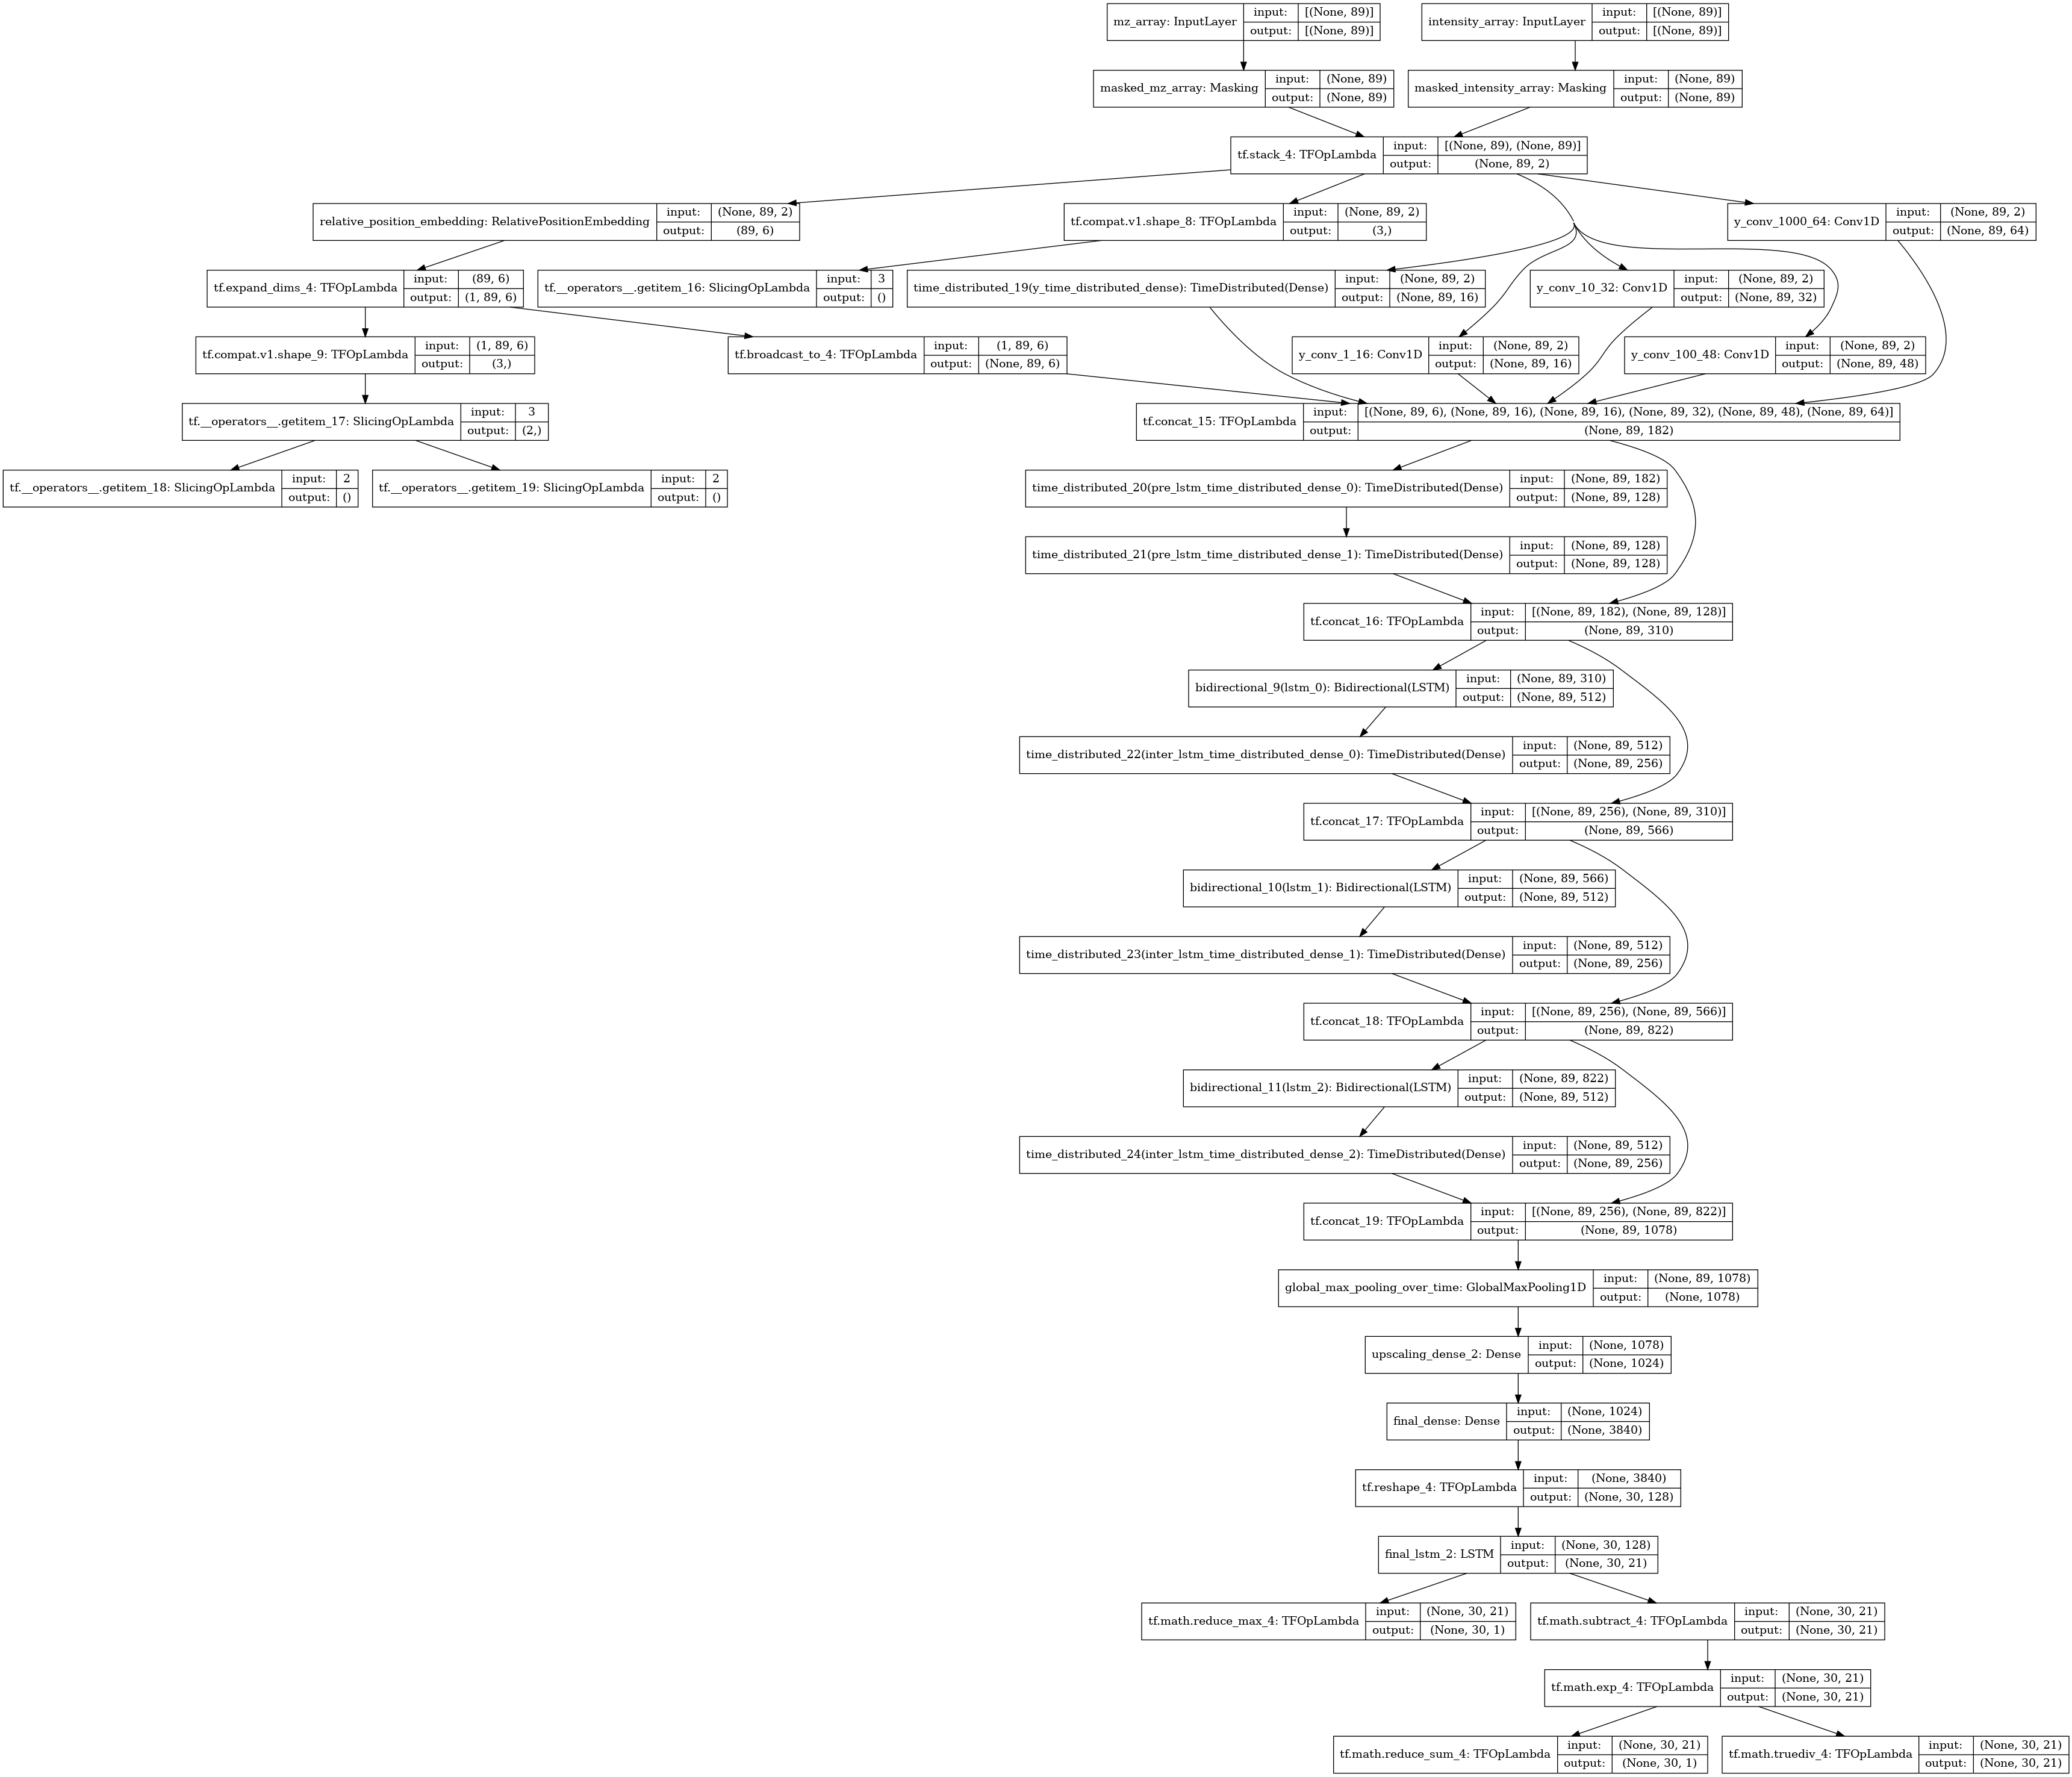

In [63]:
tf.keras.utils.plot_model(
    model=model,
    to_file=os.path.join(MODEL_PATH, "model.png"),
    show_shapes=True
)

In [64]:
with open(os.path.join(MODEL_PATH, "summary.txt"), 'w') as file:
    def write_lines(line: str) -> None:
        file.write(line)
        file.write("\n")
    model.summary(print_fn=write_lines)
model.summary()

Model: "mmproteo_lstm_with_pooling_and_position_20210722-150203"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mz_array (InputLayer)           [(None, 89)]         0                                            
__________________________________________________________________________________________________
intensity_array (InputLayer)    [(None, 89)]         0                                            
__________________________________________________________________________________________________
masked_mz_array (Masking)       (None, 89)           0           mz_array[0][0]                   
__________________________________________________________________________________________________
masked_intensity_array (Masking (None, 89)           0           intensity_array[0][0]            
____________________________________________

In [65]:
with open(os.path.join(MODEL_PATH, "model.json"), 'w') as file:
    file.write(model.to_json())

In [66]:
with open(os.path.join(MODEL_PATH, "model.yaml"), 'w') as file:
    file.write(model.to_yaml())

In [67]:
#assert False

## Training the Tensorflow Model

In [68]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [69]:
TENSORBOARD_LOG_DIR = os.path.join(MODEL_PATH, "tensorboard")
os.path.realpath(TENSORBOARD_LOG_DIR)

'/scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/tensorboard'

In [70]:
%tensorboard --logdir $TENSORBOARD_LOG_DIR --bind_all

In [72]:
model.fit(x=datasets[TRAINING_TYPE].repeat(),
          validation_data=datasets[TEST_TYPE].repeat(), 
          validation_steps=2000,
          epochs=100,
          steps_per_epoch=10_000,
          callbacks=callbacks.create_callbacks(
              tensorboard=True,
              progressbar=False,
              reduce_lr=True,
              early_stopping=False,
              checkpoints=True,
              csv=False,
              base_path=MODEL_PATH,
          )
         )

Epoch 1/100
10000/10000 [==============================] - 561s 56ms/step - loss: 2.4756 - sparse_categorical_accuracy: 0.4241 - sparse_categorical_crossentropy: 2.4756 - val_loss: nan - val_sparse_categorical_accuracy: 0.3529 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 2/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.1724 - sparse_categorical_accuracy: 0.5793 - sparse_categorical_crossentropy: 2.1724 - val_loss: nan - val_sparse_categorical_accuracy: 0.4673 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 3/100
10000/10000 [==============================] - 559s 56ms/step - loss: 2.3444 - sparse_categorical_accuracy: 0.4814 - sparse_categorical_crossentropy: 2.3444 - val_loss: nan - val_sparse_categorical_accuracy: 0.4232 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 4/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.6755 - sparse_categorical_accuracy: 0.3067 - sparse_categorical_crossentropy: 2.6755 - val_loss: nan - val_sparse_categorical_accuracy: 0.4221 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 5/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.5266 - sparse_categorical_accuracy: 0.3832 - sparse_categorical_crossentropy: 2.5266 - val_loss: nan - val_sparse_categorical_accuracy: 0.4271 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 6/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.3005 - sparse_categorical_accuracy: 0.5012 - sparse_categorical_crossentropy: 2.3005 - val_loss: nan - val_sparse_categorical_accuracy: 0.4251 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 7/100
10000/10000 [==============================] - 560s 56ms/step - loss: 2.1396 - sparse_categorical_accuracy: 0.5814 - sparse_categorical_crossentropy: 2.1396 - val_loss: nan - val_sparse_categorical_accuracy: 0.4233 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 8/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.3330 - sparse_categorical_accuracy: 0.4791 - sparse_categorical_crossentropy: 2.3330 - val_loss: nan - val_sparse_categorical_accuracy: 0.4251 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 9/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.3309 - sparse_categorical_accuracy: 0.4820 - sparse_categorical_crossentropy: 2.3309 - val_loss: nan - val_sparse_categorical_accuracy: 0.4469 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 10/100
10000/10000 [==============================] - 558s 56ms/step - loss: 2.3865 - sparse_categorical_accuracy: 0.4518 - sparse_categorical_crossentropy: 2.3865 - val_loss: nan - val_sparse_categorical_accuracy: 0.4453 - val_sparse_categorical_crossentropy: nan

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 11/100
10000/10000 [==============================] - 559s 56ms/step - loss: 2.4502 - sparse_categorical_accuracy: 0.4218 - sparse_categorical_crossentropy: 2.4502 - val_loss: nan - val_sparse_categorical_accuracy: 0.2018 - val_sparse_categorical_crossentropy: nan


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


INFO:tensorflow:Assets written to: /scratch/mirko.krause/pdeep/models/mmproteo_lstm_with_pooling_and_position_20210722-150203/checkpoints/assets


Epoch 12/100
10000/10000 [==============================] - 558s 56ms/step - loss: nan - sparse_categorical_accuracy: 0.0431 - sparse_categorical_crossentropy: nan - val_loss: nan - val_sparse_categorical_accuracy: 0.0411 - val_sparse_categorical_crossentropy: nan


InvalidArgumentError: Nan in summary histogram for: time_distributed_19/kernel_0 [Op:WriteHistogramSummary]

## Evaluating the Tensorflow Model

In [ ]:
decode_idx: Callable[[np.ndarray], np.ndarray] = np.vectorize(idx_to_char.get)

In [ ]:
evaluator = evaluation.SequenceEvaluator(
    dataset=datasets[EVAL_TYPE],
    decode_func=decode_idx,
    batch_size=BATCH_SIZE,
    separator=" ",
    padding_character=PROCESSING_INFO['padding_characters'][SEQ],
)

In [ ]:
evaluator.evaluate_model(model)

In [ ]:
eval_df, (x_eval, y_eval, y_pred) = evaluator.evaluate_model_visually(
    model=model,
    sample_size=20,
    keep_separator=True,
)
eval_df

In [ ]:
eval_df.predicted.map(print)
None

broken loss function?

In [ ]:
np.argmax(y_pred[0], axis=1)

In [ ]:
model.predict(datasets[EVAL_TYPE].take(1)).shape

In [ ]:
y_pred.shape

In [ ]:
y_pred